### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

Matplotlib is building the font cache; this may take a moment.
2024-08-04 21:46:52.625680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 21:47:17.299681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 21:47:29.654774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading and Preprocessing data

In [2]:
# Define the paths to the dataset folders
data_path ='data'
non_vehicle_folder = os.path.join(data_path, 'non-vehicles')
vehicle_folder = os.path.join(data_path, 'vehicles')

# Initialize lists to hold image data and labels
images = []
labels = []

# Counters for labeling
car_count = 0
non_car_count = 0

# Helper function to process images from a given folder
def process_images_from_folder(folder_path, is_vehicle):
    global car_count, non_car_count
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if the image couldn't be read
        
        # Resize image to 224x224 pixels
        img = cv2.resize(img, (224, 224))
        images.append(img)
        
        # Assign labels based on whether it's a vehicle or non-vehicle
        if is_vehicle:
            label = 1  # Label for car
            car_count += 1
        else:
            label = 0  # Label for non-car
            non_car_count += 1
        
        labels.append(label)

# Process images from both folders
process_images_from_folder(vehicle_folder, is_vehicle=True)
process_images_from_folder(non_vehicle_folder, is_vehicle=False)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels:", labels)


Images shape: (17760, 224, 224, 3)
Labels: [1 1 1 ... 0 0 0]


### Normalizing and Splitting data

In [3]:
# Normalize the images
images = images / 255.0

# Convert labels to categorical
labels = to_categorical(labels, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### Building the Model

CNN Model experimenting with the potential benefits by simply adding layers

In [4]:
# Initialize the model
model = Sequential()

# Add an Input layer as the first layer in the model
model.add(Input(shape=(224, 224, 3)))

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


2024-08-04 21:48:11.000695: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [5]:
# Initialize the image data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the data generator on the training data
datagen.fit(X_train)

### Training the Model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the data generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=128), 
                    epochs=50, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
111/111 [==============================] - 111s 887ms/step - loss: 0.8236 - accuracy: 0.7460 - val_loss: 0.2690 - val_accuracy: 0.8863
Epoch 2/50
111/111 [==============================] - 97s 873ms/step - loss: 0.2198 - accuracy: 0.9208 - val_loss: 0.1477 - val_accuracy: 0.9459
Epoch 3/50
111/111 [==============================] - 97s 874ms/step - loss: 0.1672 - accuracy: 0.9433 - val_loss: 0.1587 - val_accuracy: 0.9428
Epoch 4/50
111/111 [==============================] - 97s 873ms/step - loss: 0.1360 - accuracy: 0.9551 - val_loss: 0.1357 - val_accuracy: 0.9535
Epoch 5/50
111/111 [==============================] - 97s 873ms/step - loss: 0.1513 - accuracy: 0.9479 - val_loss: 0.1183 - val_accuracy: 0.9685
Epoch 6/50
111/111 [==============================] - 97s 874ms/step - loss: 0.1286 - accuracy: 0.9594 - val_loss: 0.1733 - val_accuracy: 0.9274
Epoch 7/50
111/111 [==============================] - 97s 874ms/step - loss: 0.1342 - accuracy: 0.9550 - val_loss: 0.0987 - val_a

### Evaluating the Model

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

111/111 [==============================] - 2s 18ms/step - loss: 0.0250 - accuracy: 0.9921
Test Accuracy: 99.21%


### Making Predictions

In [9]:
# Function to preprocess and predict on a new image
def predict_vehicle(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    return 'Car' if np.argmax(prediction) == 1 else 'Non-car'

# Test on a new image
test_img_path = os.path.join(vehicle_folder, '10.png')  # Corrected test image path
try:
    result = predict_vehicle(model, test_img_path)
    print(f'The image is predicted as: {result}')
except FileNotFoundError as e:
    print(e)

1/1 [==============================] - 0s 309ms/step
The image is predicted as: Car


### Visualization

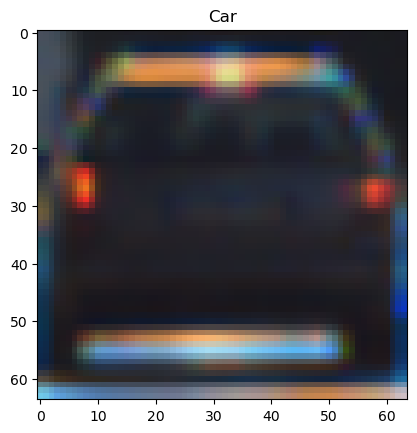

In [10]:
# Display the test image with prediction
img = cv2.imread(test_img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(result)
plt.show()

### Model Performance Report

111/111 [==============================] - 2s 18ms/step
Model Evaluation Report

1. Overall Accuracy: 99.21%
   Test Loss: 0.0250

2. Confusion Matrix:
[[1793    8]
 [  20 1731]]

3. Classification Report:
              precision    recall  f1-score   support

 Non-vehicle       0.99      1.00      0.99      1801
     Vehicle       1.00      0.99      0.99      1751

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552




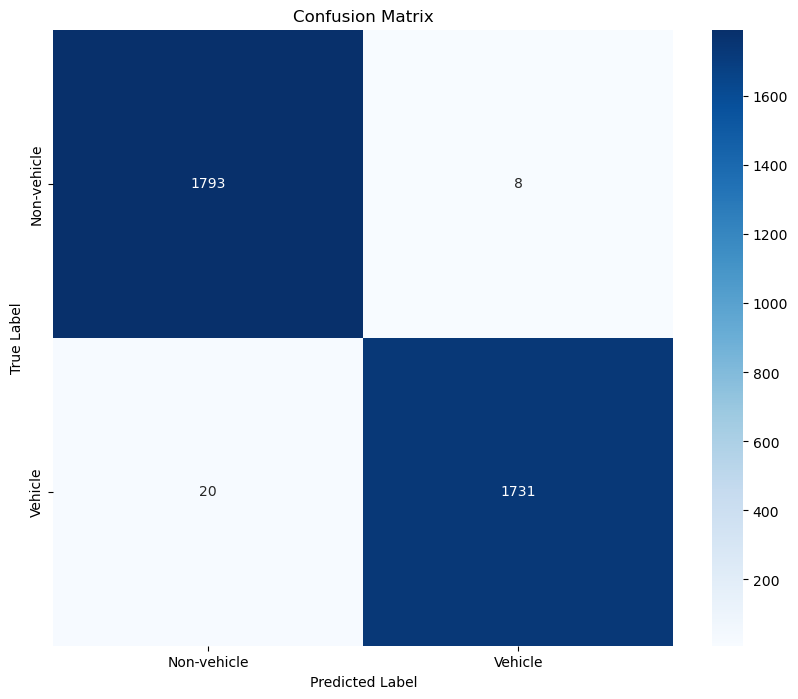

In [11]:
from IPython.display import display

def generate_model_report(model, X_test, y_test, class_names):
    report = "Model Evaluation Report\n========================\n\n"
    
    # 1. Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # 2. Overall Accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    report += f"1. Overall Accuracy: {test_accuracy*100:.2f}%\n"
    report += f"   Test Loss: {test_loss:.4f}\n\n"
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    report += "2. Confusion Matrix:\n"
    report += str(cm) + "\n\n"
    
    # 4. Classification Report
    class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
    report += "3. Classification Report:\n"
    report += class_report + "\n"
    
    # 5. Visualizations
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    return report, plt

# Example usage (you would run this after training your model)
class_names = ['Non-vehicle', 'Vehicle']
report, confusion_matrix_plot = generate_model_report(model, X_test, y_test, class_names)

# Print the report
print(report)

# Display the confusion matrix
display(confusion_matrix_plot.gcf())
plt.close()

### Saving the Model

In [16]:
# Save the trained model to a .h5 file
model.save('vehicle_detection_model.h5')
print("Model saved to 'vehicle_detection_model.h5'")

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to 'vehicle_detection_model.h5'
